In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# EDA

This resort is our largest ski resort in both capacity and the population area center close to the resort. 

A couple notes on getting the data for this particular ski area: 

* `SCHOOL_OUT` is if the public school district did not have class on a day that normally would have school (weekday). Examples include winter break, MLK Day, and teacher prep days. Weekends surrounding school closures such as Thanksgiving, Presidents Day, were not counted as a school out day. I was able to source this from the school district website. 
* Mountain Weather Data was gathered from a NOAA weather station on the mountain the resort is located, however this weather station is on a different face of the mountain and sometimes different aspects of this mountain can experience differences in weather, especially in snow and wind. 
* Wind data was not availible from the mountain weather station although my contact at the resort mentioned wind is a key factor in detering visitors or sometimes closing down the resort.

We'll first load the dataset and do some cleaning and exploration. 


### After cleaning stas

- Dataset count: 851

Daily Visitors stats:

mean     2869.439483

std      2013.683973

min       118.000000

25%      1299.000000

50%      2317.000000

75%      4062.500000

max      8719.000000

In [2]:
#Load the dataset, take a look at the data info: 
df_3 = pd.read_csv('Data/Resort_3_data.csv', thousands=',')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          851 non-null    object 
 1   IS_HOLIDAY    851 non-null    int64  
 2   SCHOOL_OUT    851 non-null    int64  
 3   DAY_VISITS    851 non-null    int64  
 4   NIGHT_VISITS  851 non-null    int64  
 5   TOTAL_VISITS  851 non-null    int64  
 6   M_PRCP        851 non-null    float64
 7   M_SNWD        851 non-null    int64  
 8   M_TAVG        851 non-null    int64  
 9   M_TMAX        851 non-null    int64  
 10  M_TMIN        851 non-null    int64  
 11  T_AWND        851 non-null    float64
 12  T_PRCP        851 non-null    float64
 13  T_SNOW        851 non-null    float64
 14  T_TAVG        851 non-null    int64  
 15  T_TMAX        851 non-null    int64  
 16  T_TMIN        851 non-null    int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 113.1+ KB


See if there's any duplicate dates:

In [3]:
df_3.duplicated().value_counts()

False    851
dtype: int64

Make the `Date` column a datetime object, create day of week and month category, we'll use these variables in our models to see if they have any predictive power.

In [4]:
#make the 'Date' Column a datetime type
df_3['Date'] = pd.to_datetime(df_3['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_3['day_of_week_num'] = df_3['Date'].dt.dayofweek

#The month column created
df_3['Month'] = df_3['Date'].dt.month


print(df_3['day_of_week_num'].value_counts())
print(df_3['Month'].value_counts())

5    136
6    135
4    130
3    113
2    113
0    113
1    111
Name: day_of_week_num, dtype: int64
1     185
12    174
3     170
2     169
4     117
11     18
5      18
Name: Month, dtype: int64


Checking to see if there's any outliers or interesting info we can learn from the stats: 

In [5]:
df_3.describe()

,IS_HOLIDAY,SCHOOL_OUT,DAY_VISITS,NIGHT_VISITS,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,M_TMAX,M_TMIN,T_AWND,T_PRCP,T_SNOW,T_TAVG,T_TMAX,T_TMIN,day_of_week_num,Month
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,0.042303,0.125734,2367.911868,1711.804935,2869.439483,0.407403,88.408931,31.263220,36.383079,26.506463,8.163561,0.142256,0.044418,44.991774,51.944771,38.554642,3.156287,4.555817
std,0.201398,0.331745,1610.007266,1418.912395,2013.683973,0.546199,37.409966,7.049325,8.000229,6.903598,4.325198,0.235899,0.418739,7.097716,9.087963,6.595382,2.012378,4.099368
min,0.000000,0.000000,42.000000,0.000000,118.000000,0.000000,9.000000,12.000000,15.000000,5.000000,0.890000,0.000000,0.000000,22.000000,28.000000,11.000000,0.000000,1.000000
25%,0.000000,0.000000,1177.000000,628.000000,1299.000000,0.000000,64.000000,27.000000,31.000000,22.000000,4.700000,0.000000,0.000000,40.000000,46.000000,34.000000,1.000000,2.000000
50%,0.000000,0.000000,1924.000000,1247.000000,2317.000000,0.200000,92.000000,31.000000,35.000000,26.000000,7.610000,0.030000,0.000000,45.000000,51.000000,39.000000,3.000000,3.000000
75%,0.000000,0.000000,3282.500000,2415.500000,4062.500000,0.600000,114.000000,35.000000,41.000000,31.000000,10.850000,0.200000,0.000000,49.000000,57.000000,43.000000,5.000000,4.000000
max,1.000000,1.000000,7120.000000,6135.000000,8719.000000,3.500000,177.000000,59.000000,67.000000,53.000000,29.530000,2.190000,6.500000,71.000000,90.000000,55.000000,6.000000,12.000000


Looking for any *null* or *NAN* values 

In [6]:
df_3.isna().sum()

Date               0
IS_HOLIDAY         0
SCHOOL_OUT         0
DAY_VISITS         0
NIGHT_VISITS       0
TOTAL_VISITS       0
M_PRCP             0
M_SNWD             0
M_TAVG             0
M_TMAX             0
M_TMIN             0
T_AWND             0
T_PRCP             0
T_SNOW             0
T_TAVG             0
T_TMAX             0
T_TMIN             0
day_of_week_num    0
Month              0
dtype: int64

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


In [7]:
#removing columns for correlation testing

df_3_corr = df_3.drop(columns=['Date', 'TOTAL_VISITS', 'DAY_VISITS', 'NIGHT_VISITS'])
df_3_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IS_HOLIDAY       851 non-null    int64  
 1   SCHOOL_OUT       851 non-null    int64  
 2   M_PRCP           851 non-null    float64
 3   M_SNWD           851 non-null    int64  
 4   M_TAVG           851 non-null    int64  
 5   M_TMAX           851 non-null    int64  
 6   M_TMIN           851 non-null    int64  
 7   T_AWND           851 non-null    float64
 8   T_PRCP           851 non-null    float64
 9   T_SNOW           851 non-null    float64
 10  T_TAVG           851 non-null    int64  
 11  T_TMAX           851 non-null    int64  
 12  T_TMIN           851 non-null    int64  
 13  day_of_week_num  851 non-null    int64  
 14  Month            851 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 99.9 KB


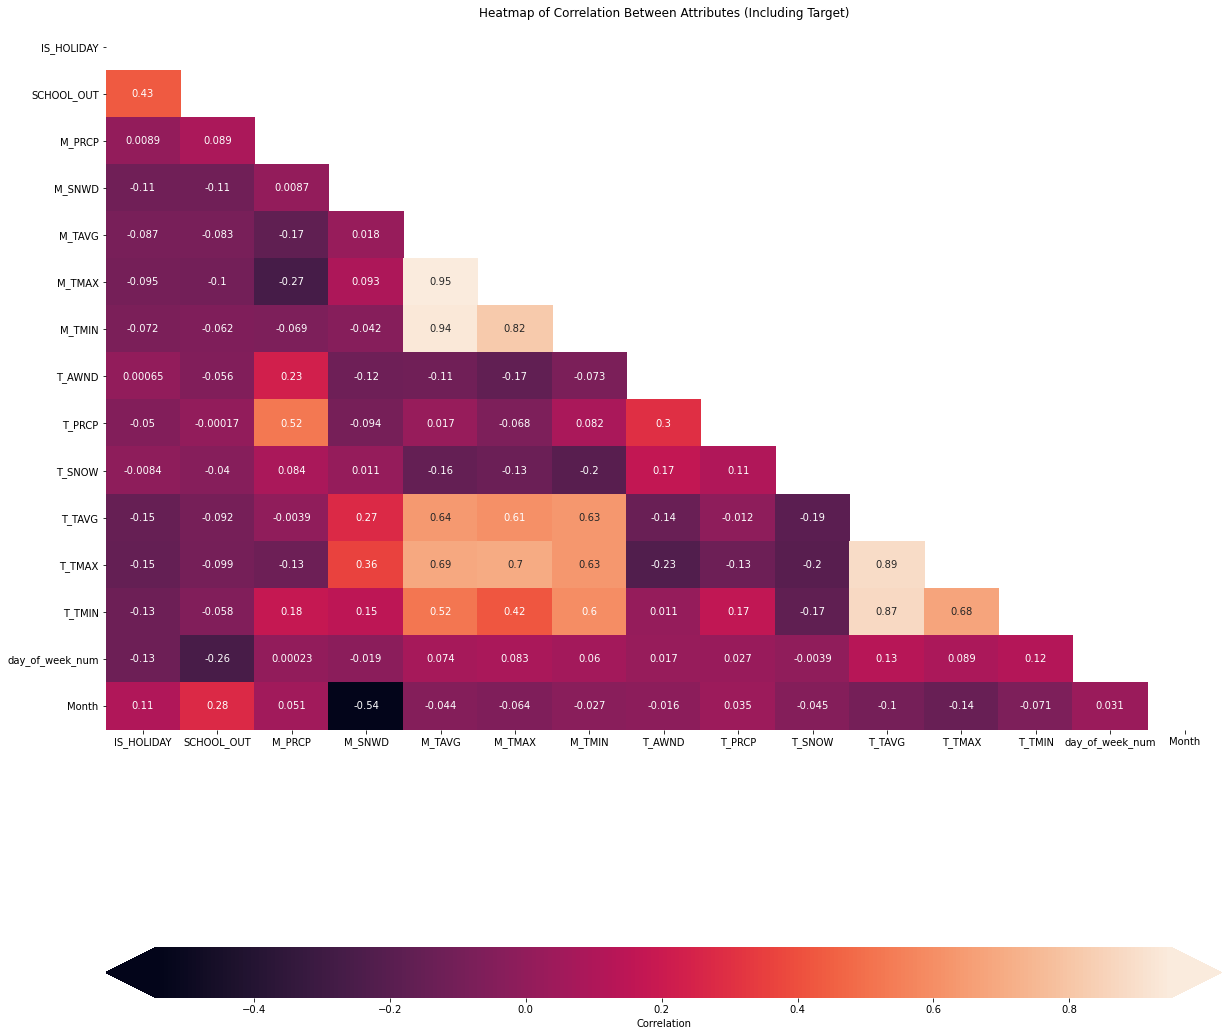

In [8]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_3_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [9]:
#identifying the highest correlated variables

df = df_3_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(M_TAVG, M_TMAX)",0.949567
"(M_TMIN, M_TAVG)",0.937526
"(T_TAVG, T_TMAX)",0.888021
"(T_TMIN, T_TAVG)",0.874355
"(M_TMAX, M_TMIN)",0.821008


### Multicollinairity decision

Based on the information above it makes sense to drop:

- Mountain Max Temperature (`M_TMAX`)
- Mountain Min Temperature (`M_TMIN`)
- Town Min Temperature (`T_MIN`)
- Town Max Temperature (`T_MAX`)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `DAY_VISITS`
- `NIGHT_VISITS`

In [10]:
df_3_preprocessed = df_3.drop(columns=['M_TMAX', 'M_TMIN', 'T_TMAX', 'T_TMIN', 'DAY_VISITS', 'NIGHT_VISITS'])
df_3_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             851 non-null    datetime64[ns]
 1   IS_HOLIDAY       851 non-null    int64         
 2   SCHOOL_OUT       851 non-null    int64         
 3   TOTAL_VISITS     851 non-null    int64         
 4   M_PRCP           851 non-null    float64       
 5   M_SNWD           851 non-null    int64         
 6   M_TAVG           851 non-null    int64         
 7   T_AWND           851 non-null    float64       
 8   T_PRCP           851 non-null    float64       
 9   T_SNOW           851 non-null    float64       
 10  T_TAVG           851 non-null    int64         
 11  day_of_week_num  851 non-null    int64         
 12  Month            851 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 86.6 KB


0 visit days: Taking a look at rows with 0 visits (these would be either an error or a the resort is closed)

In [11]:
df_3_preprocessed[df_3_preprocessed.TOTAL_VISITS == 0]

,Date,IS_HOLIDAY,SCHOOL_OUT,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month


No 0 Visit Days like the other resorts, yay!

## Indexing with Date

Making the Date the Index so it A) doesn't get mis-interpreted as a predictor in our modeling and B) so we can visualze our data better

In [12]:
#df_3_preprocessed.reset_index(inplace=True)
df_3_preprocessed.set_index('Date', inplace=True)
df_3_preprocessed.head()

,IS_HOLIDAY,SCHOOL_OUT,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month
Date,,,,,,,,,,,,
2015-11-21,0,0,588,0.0,12,36,4.92,0.00,0.0,44,5,11
2015-11-27,0,1,1196,0.0,11,35,6.26,0.00,0.0,36,4,11
2015-11-28,0,0,1668,0.0,11,38,9.17,0.00,0.0,38,5,11
2015-11-29,0,0,1328,0.0,11,39,12.30,0.00,0.0,36,6,11
2015-12-04,0,0,648,0.9,18,30,9.84,0.26,0.0,47,4,12


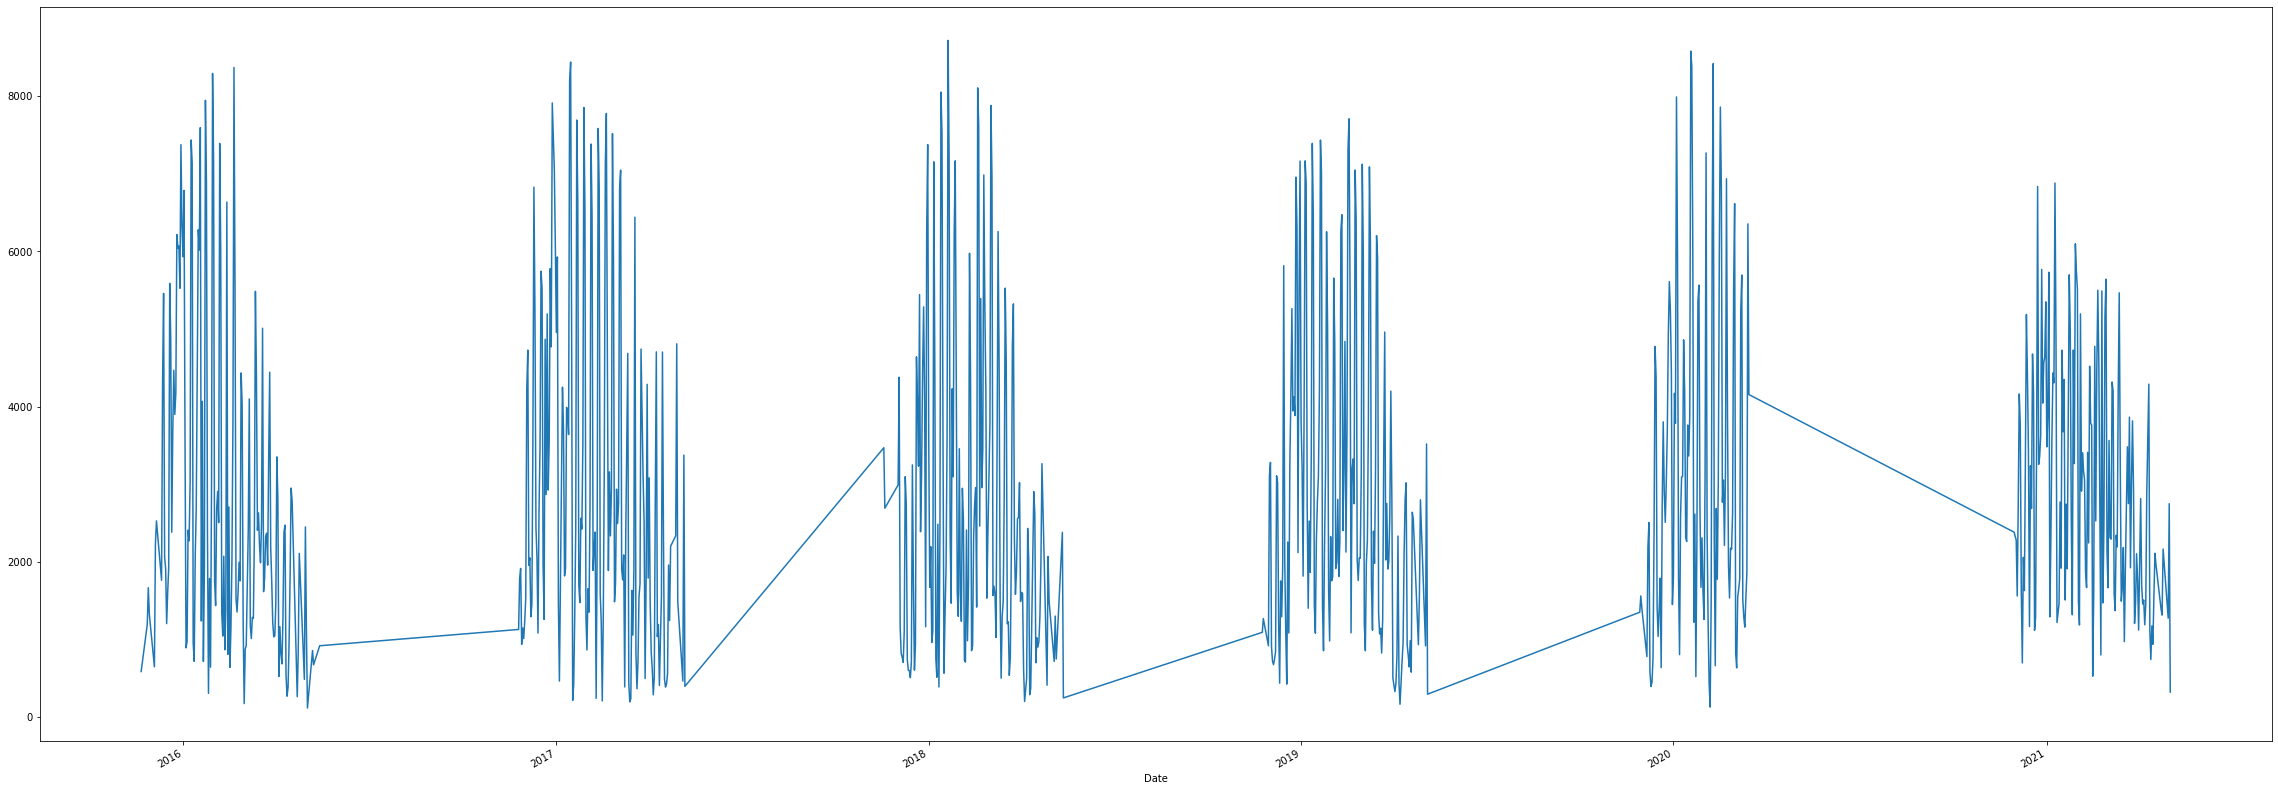

In [13]:
#Visualzing visits over time

df_3_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

## Some More Visualizations: Boxplot

This basic Boxplots, or sometimes called a box-and-whisker plot, is helpful to visualize distributions of our visitation data. The box shows the quartiles of the data and whiskers extend to show the rest of the distribution. It's helpful to see how the data is distributed. 

Month
1     3096.0
2     2630.0
3     2168.0
4     1275.0
5      804.0
11    1299.0
12    3005.5
Name: TOTAL_VISITS, dtype: float64


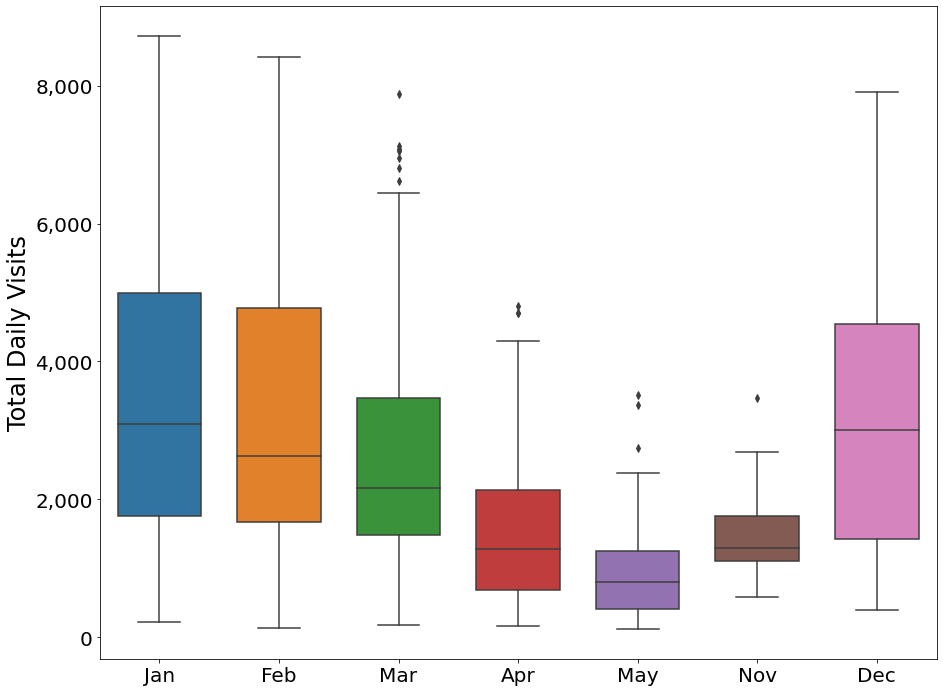

In [14]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='Month', y='TOTAL_VISITS', data=df_3_preprocessed, width=.7)

medians = df_3_preprocessed.groupby(['Month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Nov', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.savefig('Visuals/resort3visits.png', dpi=300);

Let's look at the relationship between visitors and Precipitation on the Mountain: 

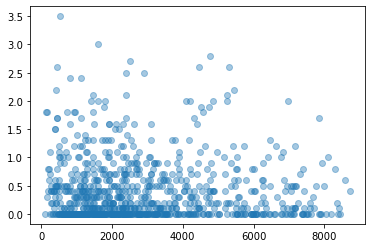

In [15]:
plt.scatter(y=df_3_preprocessed['M_PRCP'], x=df_3_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort3precip.png', dpi=300);

What about snow depth?

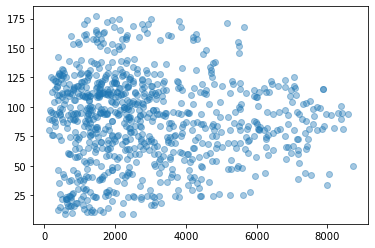

In [16]:
plt.scatter(y=df_3_preprocessed['M_SNWD'], x=df_3_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort3snowdepth.png', dpi=300);

At first glance, calendar events seem to have more impact on visitation: 

IS_HOLIDAY
0    2801.304294
1    4411.944444
Name: TOTAL_VISITS, dtype: float64
SCHOOL_OUT
0    2764.799731
1    3597.028037
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRCP', ylabel='TOTAL_VISITS'>

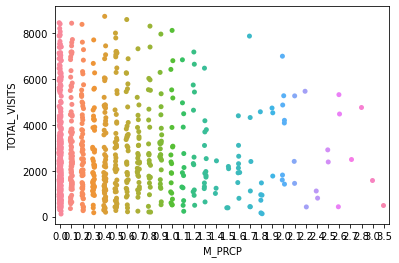

In [17]:
Holiday_averages=df_3_preprocessed.groupby(df_3_preprocessed['IS_HOLIDAY'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_3_preprocessed.groupby(df_3_preprocessed['SCHOOL_OUT'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRCP', y='TOTAL_VISITS', data=df_3_preprocessed)

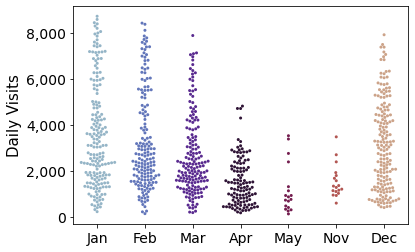

In [18]:
fig, ax = plt.subplots()
sns.swarmplot(x='Month', y='TOTAL_VISITS', data=df_3_preprocessed, size=3, palette='twilight', edgecolor='none')

ax.set_xlabel("")

ax.set_ylabel("Daily Visits", fontsize=15)

plt.yticks(fontsize=14)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Nov', 'Dec'], fontsize=14)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Visuals/resort3swarmplotmonth.png', dpi=300);

# First Simple Model
Linear Regression with Cross Validation: 

In [19]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
y.head()

Date
2015-11-21     588
2015-11-27    1196
2015-11-28    1668
2015-11-29    1328
2015-12-04     648
Name: TOTAL_VISITS, dtype: int64

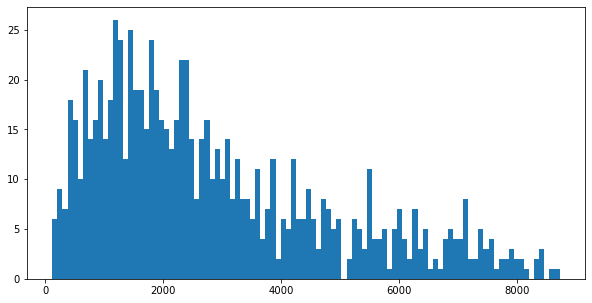

In [21]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);
plt.savefig('Visuals/resort3visitationdistribution.png', dpi=300);

In [22]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

#cross validatoin and scoring
cv = cross_validate(lr, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(lr, X_train, y_train, cv = 5)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')


Cross Validation Scores: {'fit_time': array([0.00684905, 0.00896311, 0.00386405, 0.00345516, 0.00328207]), 'score_time': array([0.00608587, 0.00356674, 0.00232601, 0.00246286, 0.00574183]), 'test_score': array([0.57242504, 0.46179001, 0.42984799, 0.44936327, 0.40957171]), 'train_score': array([0.4655157 , 0.49654377, 0.50241337, 0.49402583, 0.50436512])}
mean CV Score: 0.46459960508815146


#### Explain our simple first model

# OHE, Standard Scaler, CV in a Pipeline: 

In [23]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP', 'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(LRPipe, X_train, y_train, cv = 5)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')


Cross Validation Scores: {'fit_time': array([0.01813126, 0.01739383, 0.01971197, 0.01656103, 0.01590014]), 'score_time': array([0.0077529 , 0.009835  , 0.01016188, 0.00796008, 0.00932384]), 'test_score': array([0.73442309, 0.68680334, 0.56572863, 0.6350925 , 0.60191432]), 'train_score': array([0.65846221, 0.67246198, 0.70186861, 0.68290785, 0.68913727])}
mean CV Score: 0.6447923776236449


WOW! With Encoding and scaling, our score jumped up from .46 to .64

## Tree Regressor

In [24]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')


TreeRegPipe = Pipeline([('trans', Transformer),
                        ('treereg', DecisionTreeRegressor())])

TreeRegPipe.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(TreeRegPipe, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(TreeRegPipe, X_train, y_train, cv = 3)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')




Cross Validation Scores: {'fit_time': array([0.01544118, 0.01250029, 0.01116872, 0.01134801, 0.01232314]), 'score_time': array([0.0072    , 0.00645781, 0.00417209, 0.00660396, 0.00712705]), 'test_score': array([0.56383095, 0.55393014, 0.38671519, 0.25436103, 0.33121614]), 'train_score': array([1., 1., 1., 1., 1.])}
mean CV Score: 0.4049358433341876


Tree Regressor did not perform well.

## Decision tree is probably overfitting up there, let's do a grid search: 

In [25]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_2 = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
	'dtr__splitter': ['best', 'random'],
    'dtr__min_samples_split': [4, 6, 8, 10],
    'dtr__max_depth': [4, 5, 6, 7, 8]
}

#set up gridsearch:
gridsearch = GridSearchCV(estimator=pipeline_2,
						  param_grid=dt_param_grid,
						  cv=3)


#fit gridsearch
gridsearch.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(gridsearch, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(gridsearch, X_train, y_train, cv = 3)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch.best_params_)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Best Parameter Combination Found During Grid Search:
{'dtr__max_depth': 8, 'dtr__min_samples_split': 8, 'dtr__splitter': 'random'}
Cross Validation Scores: {'fit_time': array([2.72712612, 2.69730401, 2.70421696, 2.66567016, 2.68958473]), 'score_time': array([0.00414681, 0.00381684, 0.00449204, 0.00399399, 0.00434613]), 'test_score': array([0.65302791, 0.59104961, 0.5635716 , 0.3864217 , 0.4335553 ]), 'train_score': array([0.75370329, 0.6514675 , 0.72082512, 0.77392192, 0.74166878])}
mean CV Score: 0.5255252251429198


## Wanna try Random Forests? 

In [26]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=3)

#fit gridsearch
gridsearch2.fit(X_train, y_train)


print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)

Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mae', 'dtr__max_depth': None, 'dtr__max_features': 'sqrt', 'dtr__n_estimators': 16}


In [31]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(criterion = 'mae', max_depth = None, max_features = 'sqrt', n_estimators = 16, random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])


pipeline_3.fit(X_train, y_train)

cv = cross_validate(pipeline_3, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(pipeline_3, X_train, y_train, cv = 3)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.13333511, 0.15272403, 0.18827915]), 'score_time': array([0.01017594, 0.00619912, 0.01273108]), 'test_score': array([0.71286601, 0.67772035, 0.64059778]), 'train_score': array([0.93525781, 0.93872223, 0.94082182])}
mean CV Score: 0.6770613804769828


For this dataset, forests are performing better than trees with a CV score of .68!

In [34]:
for name, importance in zip(X_train.columns, pipeline_3['dtr'].feature_importances_):
    print(name, importance)

IS_HOLIDAY 0.006617936365220919
SCHOOL_OUT 0.008582555747591127
M_PRCP 0.02197206945985978
M_SNWD 0.011198721183868521
M_TAVG 0.014920460729298542
T_AWND 0.02726267601216032
T_PRCP 0.013217708872981258
T_SNOW 0.008833922687237428
T_TAVG 0.014916829316857965
day_of_week_num 0.09405630498446836
Month 0.07633957877659191


## Gradient Boosting: 

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch3.best_params_)


Best Parameter Combination Found During Grid Search:
{'gbr__criterion': 'friedman_mse', 'gbr__min_samples_split': 2, 'gbr__n_estimators': 300}


In [82]:
#Using best params on a gradient booster regressor then scoring thorugh cross val: 

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
# GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, random_state = 42)
GBR = GradientBoostingRegressor(criterion='friedman_mse', n_estimators=300, min_samples_split= 2, random_state = 42)

#pipeline
pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_gbr.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr, X_train, y_train, cv = 5)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.43120384, 0.42871904, 0.90100217, 0.60639095, 0.57176709]), 'score_time': array([0.01291299, 0.00537705, 0.01061988, 0.00806022, 0.0086441 ]), 'test_score': array([0.8251312 , 0.74713871, 0.73985765, 0.65121635, 0.66878979]), 'train_score': array([0.95344752, 0.95724635, 0.95822641, 0.95579781, 0.96307766])}
mean CV Score: 0.7264267390320679


### Gradient Booster Regressor Is doing the best: 
And more improvement! We got our model CV score up to .72

In [41]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#x_boost Pipe:

X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP', 'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_boost.best_params_)

Best Parameter Combination Found During Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 5}


In [45]:
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP', 'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_2 = xg.XGBRegressor(eta = 0.2, max_depth = 5, seed = 123)

xboostPipe_2 = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_2)])

xboostPipe_2.fit(X_train, y_train)

cv = cross_validate(xboostPipe_2, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboostPipe_2, X_train, y_train, cv = 5)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.19820499, 0.25633216, 0.42141175, 0.27408409, 0.36398125]), 'score_time': array([0.01532316, 0.01708388, 0.02244711, 0.01603007, 0.01038575]), 'test_score': array([0.80411142, 0.73072951, 0.75581751, 0.68066374, 0.66995498]), 'train_score': array([0.98977209, 0.99254808, 0.99187122, 0.99222901, 0.99111153])}
mean CV Score: 0.7282554295490252


In [46]:
xboostPipe_2.score(X_test, y_test)

0.6817334831378453

X boost is not as good as the Gradient Booster Regressor

## Evaluation

**Gradient Booster Regressor** 

CV score up to .72

In [57]:
#GBR Test Score
pipeline_gbr.score(X_test, y_test)

0.7480296743794888

Gradient Booster Regressor gets a test CV score of .75, this means we can account for 75% of the variance in the data with our Gradient Booster Regressor model. 

In [58]:
y_pred_boost = pipeline_gbr.predict(X_test)

df = pd.DataFrame({'Real Visits':y_test, 'Predicted Visits':y_pred_boost, 'Difference': abs(y_test - y_pred_boost)})
df.head()


,Real Visits,Predicted Visits,Difference
Date,,,
2016-02-08,1349,1465.854441,116.854441
2017-12-14,509,526.281075,17.281075
2020-01-26,5566,4387.935248,1178.064752
2021-03-01,2141,1647.557957,493.442043
2018-03-06,1687,2003.740274,316.740274


In [60]:
df['Difference'].mean()

786.7362503675406

In [77]:
for name, importance in zip(X_train.columns, pipeline_gbr['gbr'].feature_importances_):
    print(name, importance)

IS_HOLIDAY 0.005350874075512237
SCHOOL_OUT 0.004587395982331858
M_PRCP 0.03238259373895249
M_SNWD 0.05488942178256012
M_TAVG 0.007401551204668465
T_AWND 0.03640374932573139
T_PRCP 0.004200108965867239
T_SNOW 0.0025662065539434663
T_TAVG 0.00873709750198094
day_of_week_num 0.15975318863796856
Month 0.15933176264409388


In [85]:
ohe = pipeline_gbr.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, pipeline_gbr['gbr'].feature_importances_):
    print(name, importance)


x0_0 0.005350874075512237
x0_1 0.004587395982331858
x1_0 0.03238259373895249
x1_1 0.05488942178256012
x2_0 0.007401551204668465
x2_1 0.03640374932573139
x2_2 0.004200108965867239
x2_3 0.0025662065539434663
x2_4 0.00873709750198094
x2_5 0.15975318863796856
x2_6 0.15933176264409388
x3_1 0.03811900748245936
x3_2 0.006593565817260577
x3_3 0.003741990974228407
x3_4 0.0156080167525943
x3_5 0.009742277086497683
x3_11 0.004392821606088552
x3_12 0.0036992682617576107
M_PRCP 0.017632217953071332
M_SNWD 0.12250960558558065
M_TAVG 0.08248277748244459
T_AWND 0.03317864124393737
T_PRCP 0.025919228508798436
T_SNOW 0.0013891018976973492
T_TAVG 0.15938752893397315


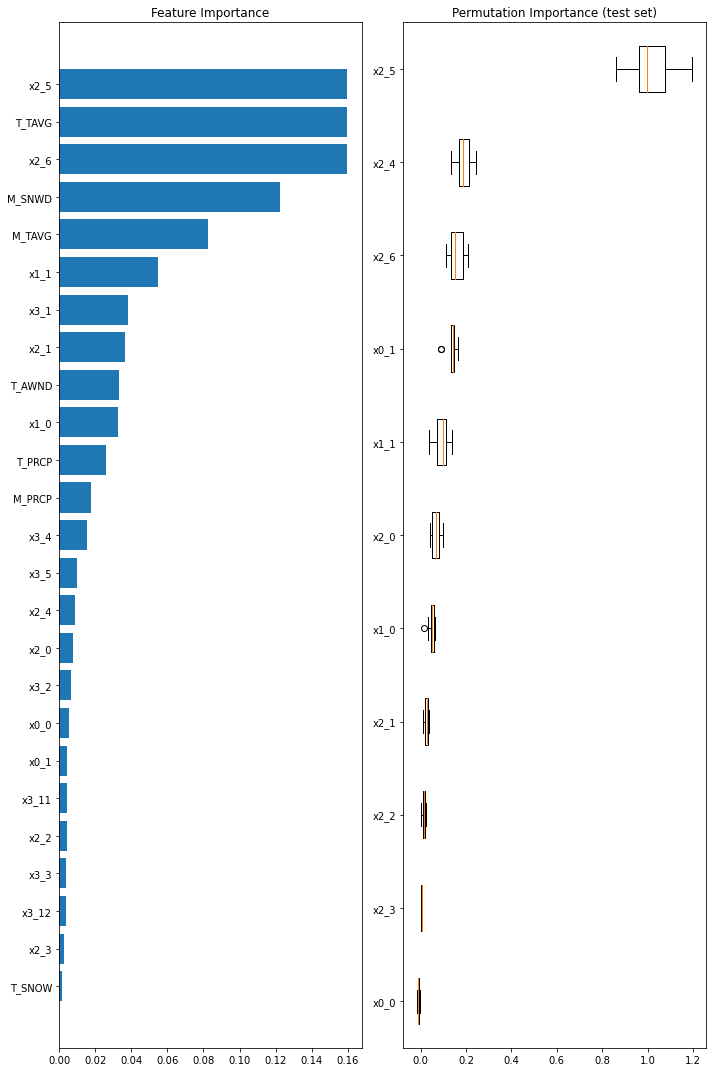

In [90]:
from sklearn.inspection import permutation_importance

feature_importance = pipeline_gbr['gbr'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    pipeline_gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [65]:
feature_importance

array([0.00535087, 0.0045874 , 0.03238259, 0.05488942, 0.00740155,
       0.03640375, 0.00420011, 0.00256621, 0.0087371 , 0.15975319,
       0.15933176, 0.03811901, 0.00659357, 0.00374199, 0.01560802,
       0.00974228, 0.00439282, 0.00369927, 0.01763222, 0.12250961,
       0.08248278, 0.03317864, 0.02591923, 0.0013891 , 0.15938753])

In [92]:
df_3_preprocessed[df_3_preprocessed.index == '2021/03/01']

,IS_HOLIDAY,SCHOOL_OUT,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month
Date,,,,,,,,,,,,
2021-03-01,0,0,2141,0.0,165,35,2.91,0.0,0.0,48,0,3
